In [0]:
import pyspark.sql.functions as F
from  pyspark.sql.functions import col, struct, to_json
from pyspark.sql.types import StructField, StructType, StringType, MapType
import pandas as pd

In [0]:
%fs ls /FileStore/tables/

path,name,size,modificationTime
dbfs:/FileStore/tables/FileStore/,FileStore/,0,1703145577206
dbfs:/FileStore/tables/mock_heart_health_dataset-1.csv,mock_heart_health_dataset-1.csv,19228644,1703143904827
dbfs:/FileStore/tables/mock_heart_health_dataset.csv,mock_heart_health_dataset.csv,19228644,1703142736277


**Streaming Consumer Data Stream into Databricks**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField

# Create a Spark session
spark = SparkSession.builder.appName("KafkaSparkStructuredStreamingApp").getOrCreate()

# Define Kafka parameters
kafka_bootstrap_servers = "pkc-4r087.us-west2.gcp.confluent.cloud:9092"  # Replace with your Kafka bootstrap servers
kafka_topic = "health_data"  # Replace with your Kafka topic

# Define the schema for the incoming Kafka data
json_schema = StructType([
    StructField("User ID", StringType(), True),
    StructField("Age", StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("Heart Rate", StringType(), True),
    StructField("Blood Pressure", StringType(), True),
    StructField("Steps Count", StringType(), True),
    StructField("Exercise Duration", StringType(), True),
    StructField("Sleep Duration", StringType(), True),
    StructField("Sleep Quality", StringType(), True),
    StructField("Blood Oxygen Level (SpO2)", StringType(), True),
    StructField("BMI", StringType(), True),
    StructField("Stress Level", StringType(), True),
    StructField("Total Distance Covered", StringType(), True),
    StructField("Blood Glucose Levels", StringType(), True),
])

# Read data from the provided CSV dataset
dataset_path = "/FileStore/tables/mock_heart_health_dataset.csv"
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(dataset_path)

# Display input data
df.show(truncate=False)

# Write to Kafka topic
(df.selectExpr("CAST(`User ID` AS STRING) AS key", "to_json(struct(*)) AS value") \
  .write \
  .format("kafka") \
  .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \
  .option("topic", kafka_topic) \
  .option("kafka.security.protocol", "SASL_SSL") \
  .option("kafka.sasl.mechanism", "PLAIN") \
  .option("kafka.sasl.jaas.config", """kafkashaded.org.apache.kafka.common.security.plain.PlainLoginModule required username="IC36SACAFDAJF3XK" password="V3SFQOJTbhkplNV82nM1akV2RZSnhdfyxpyhY1sOvTX++iMWzvF/zx8xa1utwudd";""") \
  .save()
)


+-------+---+------+----------+--------------+-----------+-----------------+--------------+-------------+-------------------------+----+------------+----------------------+--------------------+
|User ID|Age|Gender|Heart Rate|Blood Pressure|Steps Count|Exercise Duration|Sleep Duration|Sleep Quality|Blood Oxygen Level (SpO2)|BMI |Stress Level|Total Distance Covered|Blood Glucose Levels|
+-------+---+------+----------+--------------+-----------+-----------------+--------------+-------------+-------------------------+----+------------+----------------------+--------------------+
|1      |62 |Female|57        |160/90        |271        |90               |8.0           |2            |93.4                     |20.3|1           |0.91                  |100.2368191436522   |
|2      |65 |Male  |69        |156/75        |1175       |152              |10.7          |5            |99.4                     |30.1|4           |11.2                  |178.85183440795768  |
|3      |71 |Male  |91        

In [0]:
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.functions import corr
import seaborn as sns
import os
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import when, col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.driver.memory','8g')
conf.set('spark.ui.showConsoleProgress', False)
conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
try:
    sc = pyspark.SparkContext(conf=conf)
    spark = pyspark.SQLContext.getOrCreate(sc)
except:
    print('Spark context already exists, continuing with', sc)

Spark context already exists, continuing with <SparkContext master=spark://driver-proxy:7077 appName=Databricks Shell>


In [0]:
from pyspark.sql.functions import split
df = df.withColumn("BloodPressureSystolic", split(col("Blood Pressure"), "/")[0].cast("double"))
df = df.withColumn("BloodPressureDiastolic", split(col("Blood Pressure"), "/")[1].cast("double"))

# Drop the original 'Blood Pressure' column if needed
df = df.drop("Blood Pressure")

# Display the updated DataFrame
df.show(truncate=False)

+-------+---+------+----------+-----------+-----------------+--------------+-------------+-------------------------+----+------------+----------------------+--------------------+---------------------+----------------------+
|User ID|Age|Gender|Heart Rate|Steps Count|Exercise Duration|Sleep Duration|Sleep Quality|Blood Oxygen Level (SpO2)|BMI |Stress Level|Total Distance Covered|Blood Glucose Levels|BloodPressureSystolic|BloodPressureDiastolic|
+-------+---+------+----------+-----------+-----------------+--------------+-------------+-------------------------+----+------------+----------------------+--------------------+---------------------+----------------------+
|1      |62 |Female|57        |271        |90               |8.0           |2            |93.4                     |20.3|1           |0.91                  |100.2368191436522   |160.0                |90.0                  |
|2      |65 |Male  |69        |1175       |152              |10.7          |5            |99.4          

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("KafkaSparkStructuredStreamingApp").getOrCreate()

# Assuming 'df' is your existing DataFrame
# Define the desired order of columns
desired_order = ["User ID", "Age", "Gender", "Heart Rate", "Steps Count", "Total Distance Covered", "BloodPressureSystolic", "BloodPressureDiastolic", "Blood Oxygen Level (SpO2)",
                 "Exercise Duration", "Sleep Duration", "Sleep Quality", 
                 "BMI", "Stress Level", "Blood Glucose Levels"]

# Reorder the columns based on the desired order
df = df.select(desired_order)

# Sort the DataFrame based on 'User ID' column (similar to set_index in pandas)
df = df.orderBy(col("User ID"))

# Display the updated DataFrame
df.show(truncate=False)


+-------+---+------+----------+-----------+----------------------+---------------------+----------------------+-------------------------+-----------------+--------------+-------------+----+------------+--------------------+
|User ID|Age|Gender|Heart Rate|Steps Count|Total Distance Covered|BloodPressureSystolic|BloodPressureDiastolic|Blood Oxygen Level (SpO2)|Exercise Duration|Sleep Duration|Sleep Quality|BMI |Stress Level|Blood Glucose Levels|
+-------+---+------+----------+-----------+----------------------+---------------------+----------------------+-------------------------+-----------------+--------------+-------------+----+------------+--------------------+
|1      |62 |Female|57        |271        |0.91                  |160.0                |90.0                  |93.4                     |90               |8.0           |2            |20.3|1           |100.2368191436522   |
|2      |65 |Male  |69        |1175       |11.2                  |156.0                |75.0            

In [0]:
df = df.withColumn('HeartAttackRisk',
                   when(
                       (col('BloodPressureSystolic') > 140) & 
                       (col('BloodPressureDiastolic') > 90) &
                       (col('Heart Rate') < 90) | (col('Heart Rate') > 120) &
                       (col('Blood Oxygen Level (SpO2)') < 95), 'High'
                   ).otherwise('Low'))

In [0]:
df.show()

+-------+---+------+----------+-----------+----------------------+---------------------+----------------------+-------------------------+-----------------+--------------+-------------+----+------------+--------------------+---------------+
|User ID|Age|Gender|Heart Rate|Steps Count|Total Distance Covered|BloodPressureSystolic|BloodPressureDiastolic|Blood Oxygen Level (SpO2)|Exercise Duration|Sleep Duration|Sleep Quality| BMI|Stress Level|Blood Glucose Levels|HeartAttackRisk|
+-------+---+------+----------+-----------+----------------------+---------------------+----------------------+-------------------------+-----------------+--------------+-------------+----+------------+--------------------+---------------+
|      1| 62|Female|        57|        271|                  0.91|                160.0|                  90.0|                     93.4|               90|           8.0|            2|20.3|           1|   100.2368191436522|            Low|
|      2| 65|  Male|        69|       11

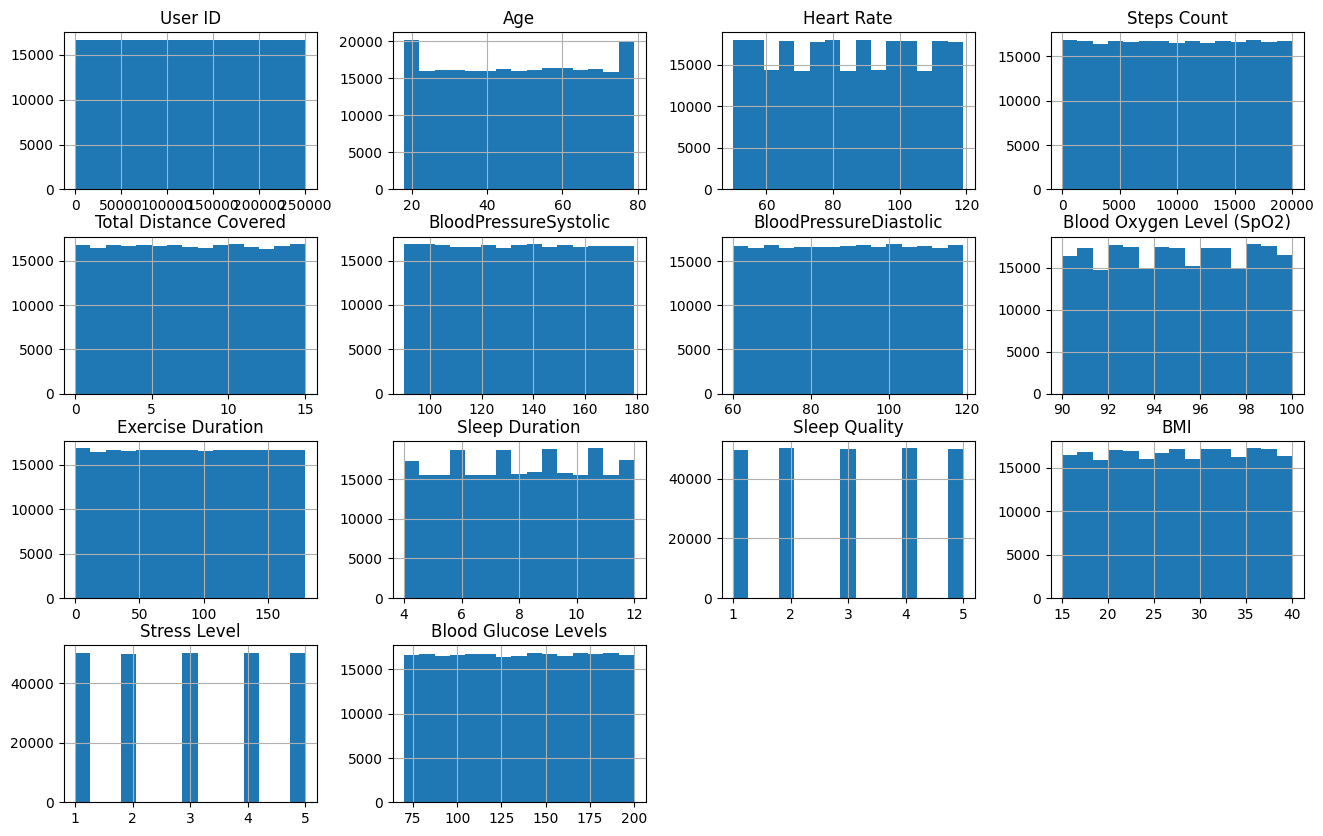

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
health = df.toPandas()
health.hist(bins=15, figsize=(16,10)) #figsize = (width, height)
plt.show()

In [0]:
attributes = ['Steps Count', 'Heart Rate', 'BloodPressureSystolic','BloodPressureDiastolic','Blood Oxygen Level (SpO2)']
corr_matrix = df.select([corr(col1, col2).alias(f"corr_{col1}_{col2}") for col1 in attributes for col2 in attributes]).toPandas()


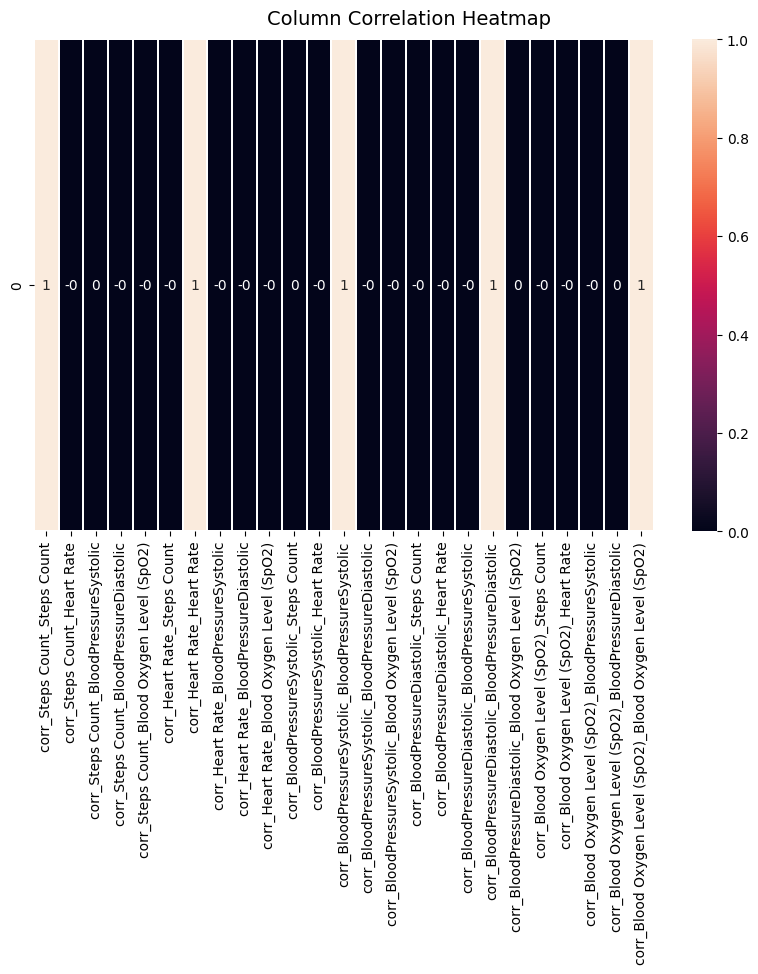

In [0]:
f, ax = plt.subplots(figsize=(10, 6))
hm = sns.heatmap(round(corr_matrix,2), annot=True, ax=ax,
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Column Correlation Heatmap', fontsize=14)

**Decison Tree Model**

In [0]:
# Define the features
features = ['Steps Count', 'Heart Rate', 'BloodPressureSystolic', 'BloodPressureDiastolic', 'Blood Oxygen Level (SpO2)']

# Assemble the features into a single feature vector
df = df.drop('features')
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Convert categorical labels to numerical labels
df = df.withColumn("label", when(col("HeartAttackRisk") == "High", 1).otherwise(0))

# Split the data into training and test sets
train, test = df.randomSplit([0.2, 0.8], seed=42)

# Define and fit the Decision Tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
model = dt.fit(train)

# Make predictions
predictions = model.transform(test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)
# View the decision tree model 
print(model.toDebugString)

Test Accuracy: 0.9924415574000561
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_94f7f1b5334c, depth=5, numNodes=15, numClasses=2, numFeatures=5
  If (feature 2 <= 140.5)
   Predict: 0.0
  Else (feature 2 > 140.5)
   If (feature 3 <= 89.5)
    Predict: 0.0
   Else (feature 3 > 89.5)
    If (feature 1 <= 88.5)
     If (feature 3 <= 91.5)
      If (feature 0 <= 4217.0)
       Predict: 1.0
      Else (feature 0 > 4217.0)
       Predict: 0.0
     Else (feature 3 > 91.5)
      Predict: 1.0
    Else (feature 1 > 88.5)
     If (feature 1 <= 90.5)
      If (feature 0 <= 2962.5)
       Predict: 0.0
      Else (feature 0 > 2962.5)
       Predict: 1.0
     Else (feature 1 > 90.5)
      Predict: 0.0



**We used a decision Tree model to train the data, we chose this approach because decison tree performs well when there are many features that affect our binary classifcation. However, the model resulted in an accuracy of 99.24% indicating a clear case of overfitting. Inorder to overcome this issue we chose to use Logistical Regression to solve our classification problem.**

**Decision Tree - Confusion Matrix**

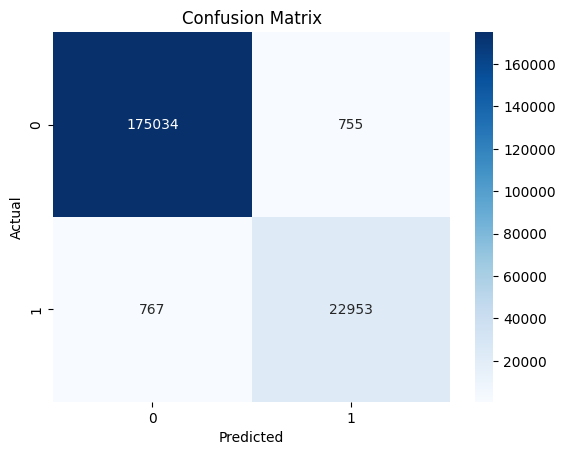

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert Spark DataFrame to Pandas DataFrame for visualization
predictions_pd = predictions.select("label", "prediction").toPandas()

# Create a confusion matrix
conf_matrix = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**We are using Logistic Regression to overcome our problem of overfitting.**

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col

# Create a Spark session
spark = SparkSession.builder.appName("HeartAttackRiskPrediction").getOrCreate()

# Assuming df is your DataFrame with the provided dataset


# Define the features
features = ['Steps Count', 'Heart Rate', 'BloodPressureSystolic', 'BloodPressureDiastolic', 'Blood Oxygen Level (SpO2)']

# Assemble the features into a single feature vector
df = df.drop('features')
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Convert categorical labels to numerical labels
df = df.withColumn("label", when(col("HeartAttackRisk") == "High", 1).otherwise(0))

# Split the data into training and test sets
train, test = df.randomSplit([0.5, 0.5], seed=42)

# Define classifiers
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Create a pipeline for each classifier
pipeline_lr = Pipeline(stages=[lr])

# Fit the models
model_lr = pipeline_lr.fit(train)

# Make predictions on the test data
predictions_lr = model_lr.transform(test)

# Evaluate the models
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator.evaluate(predictions_lr)
print("Logistic Regression Test Accuracy:", accuracy_lr)


Logistic Regression Test Accuracy: 0.9360847070147996


**Implementing Binary Classification Through Logistic Regression Model**

**Output**

In [0]:
# Assuming 'predictions' DataFrame contains the output of logistic regression predictions
# Display columns like 'label', 'prediction', and any other columns you are interested in
predictions.select("label", "prediction", "probability").show(truncate=False)


+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |1.0       |[0.35802469135802467,0.6419753086419753]|
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|0    |0.0       |[1.0,0.0]                               |
|1    |1.0       |[0.0,1.0]                               |
|0    |0.0       |[1.0,0.0]             

**Correlation Heatmap**

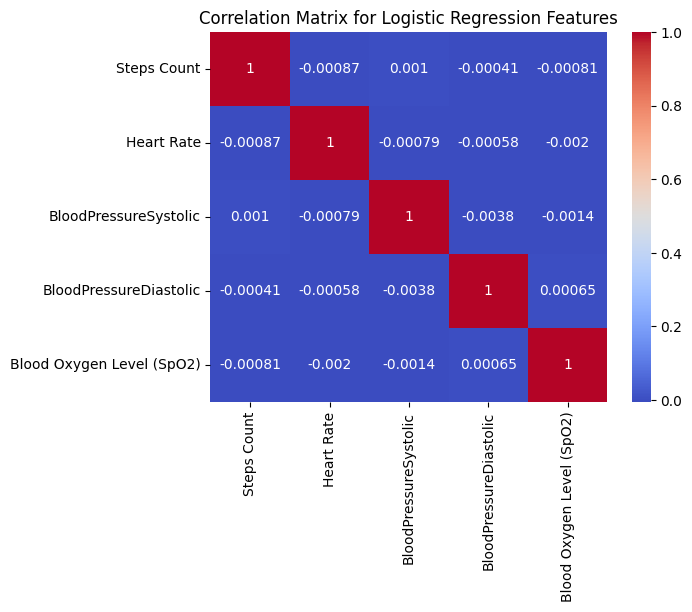

In [0]:
# Define the features
assembler1 = VectorAssembler(inputCols=features, outputCol="features_temp")
df = assembler1.transform(df)

# Assemble the features into a single feature vector
df = df.drop('features')
assembler2 = VectorAssembler(inputCols=features, outputCol="features")
df = assembler2.transform(df)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df, "features").head()

# Extract the correlation matrix as a NumPy array
corr_matrix = correlation_matrix[0].toArray()

# Display the correlation matrix using seaborn heatmap
sns.heatmap(corr_matrix, annot=True, xticklabels=features, yticklabels=features, cmap="coolwarm")
plt.title("Correlation Matrix for Logistic Regression Features")
plt.show()

**Confusion Matrix**

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
# Evaluate the Logistic Regression model
evaluator_lr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator_lr.evaluate(predictions_lr)

# Calculate TP, TN, FP, FN
tp_lr = predictions_lr.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn_lr = predictions_lr.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp_lr = predictions_lr.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn_lr = predictions_lr.filter((col("label") == 1) & (col("prediction") == 0)).count()

# Construct the confusion matrix with labels
confusion_matrix_lr = spark.createDataFrame([(tp_lr, fp_lr), (fn_lr, tn_lr)], ["Actual Positive", "Actual Negative"])
confusion_matrix_lr = confusion_matrix_lr.withColumn("Predicted Positive", lit("Positive")).withColumn("Predicted Negative", lit("Negative"))

# Display the confusion matrix
confusion_matrix_lr.show()


+---------------+---------------+------------------+------------------+
|Actual Positive|Actual Negative|Predicted Positive|Predicted Negative|
+---------------+---------------+------------------+------------------+
|           9785|           2824|          Positive|          Negative|
|           5090|         106986|          Positive|          Negative|
+---------------+---------------+------------------+------------------+



In the confusion matrix:

Actual Positive (TP - True Positive): 9785

This represents the number of instances where the actual class is positive (High Heart Attack Risk), and the model correctly predicted them as positive.
Actual Negative (TN - True Negative): 106986

This represents the number of instances where the actual class is negative (Low Heart Attack Risk), and the model correctly predicted them as negative.
Predicted Positive (FP - False Positive): 2824

This represents the number of instances where the actual class is negative, but the model incorrectly predicted them as positive.
Predicted Negative (FN - False Negative): 5090

This represents the number of instances where the actual class is positive, but the model incorrectly predicted them as negative.